# How Multilingual is Multilingual BERT?
Fine-Tuning a Multilingual Model and Zero-Shot Learning

## 1. Introduction

In [ ]:
!pip install transformers[torch]
!pip install transformers datasets
#!pip install codecarbon
!pip install spacy
!pip install conllu
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00


In [ ]:
#from codecarbon import EmissionsTracker
import spacy
from google.colab import drive
import conllu
from collections import Counter
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


## 2 Fine-Tuning mBERT

In [ ]:
# Download dataset
# !wget -P /content/drive/MyDrive/Multilingual_NLP/Lab_4 https://raw.githubusercontent.com/UniversalDependencies/UD_French-Sequoia/master/fr_sequoia-ud-test.conllu
# !wget -P /content/drive/MyDrive/Multilingual_NLP/Lab_4 https://raw.githubusercontent.com/UniversalDependencies/UD_French-Sequoia/master/fr_sequoia-ud-train.conllu
# !wget -P /content/drive/MyDrive/Multilingual_NLP/Lab_4 https://raw.githubusercontent.com/UniversalDependencies/UD_French-Sequoia/master/fr_sequoia-ud-dev.conllu

In [ ]:
def load_conllu(file_path):
  for sentence in conllu.parse(open(file_path, 'rt', encoding='utf-8').read()):
    tokenized_words = [token['form'] for token in sentence]
    gold_tags = [token["upos"] for token in sentence]
    yield tokenized_words, gold_tags

corpus = list(load_conllu("/content/drive/MyDrive/Multilingual_NLP/Lab_4_How Multilingual is Multilingual BERT?/fr_sequoia-ud-test.conllu"))

2.1 The Universal Dependencies Project

3. What is the distribution of labels in the test set of the Sequoia treebank ?

In [ ]:
labels = [elt[1] for elt in corpus]
labels_count = {}

for liste in labels:
  for elt in liste:
    if elt not in labels_count:
      labels_count[elt] = 1
    else:
      labels_count[elt] += 1

labels_count_alphabetic_order = {k: v for k, v in sorted(labels_count.items())}
labels_count_value_order = {k: v for k, v in sorted(labels_count.items(), key=lambda item: item[1], reverse=True)}
labels_count_value_order

{'NOUN': 2158,
 'ADP': 1634,
 'DET': 1493,
 'PUNCT': 1084,
 'VERB': 781,
 'ADJ': 638,
 'PROPN': 486,
 'ADV': 411,
 'PRON': 410,
 'AUX': 345,
 '_': 310,
 'NUM': 240,
 'CCONJ': 222,
 'SCONJ': 106,
 'X': 33,
 'SYM': 3}

In [ ]:
labels_count = dict(Counter(elt for sublist in labels for elt in sublist))
labels_count

{'PRON': 410,
 'VERB': 781,
 'SCONJ': 106,
 'DET': 1493,
 'NOUN': 2158,
 'ADJ': 638,
 'PUNCT': 1084,
 'ADV': 411,
 'NUM': 240,
 'ADP': 1634,
 'PROPN': 486,
 'CCONJ': 222,
 'AUX': 345,
 '_': 310,
 'X': 33,
 'SYM': 3}

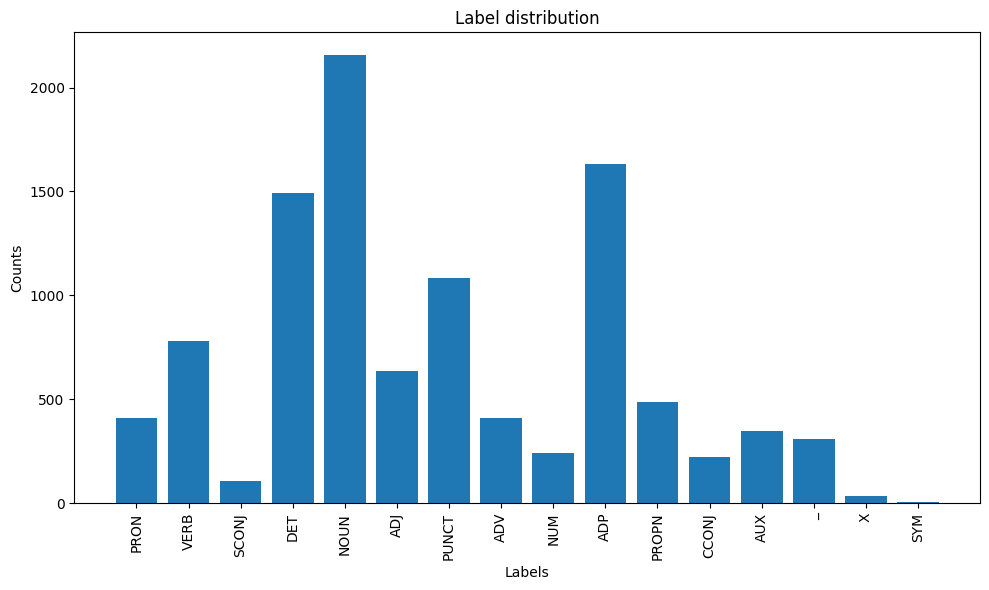

In [ ]:
labels = list(labels_count.keys())
counts = list(labels_count.values())
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

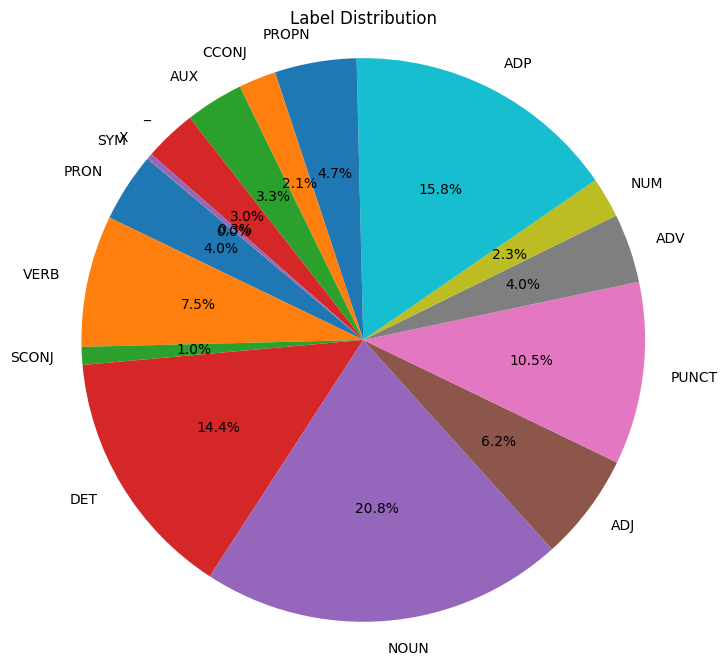

In [ ]:
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Label Distribution')
plt.show()

4. What are the multiword tokens in the test set of Sequoia? How are they annotated ?

In [ ]:
# Mapping the labels and the words
i2w = [word for sentence in corpus for word in sentence[0]]
w2i = {word: i for i, word in enumerate(set(word for word in i2w), 1)}
i2l = [label for sentence in corpus for label in sentence[1]]
l2i = {label: i for i, label in enumerate(set(label for label in i2l), 1)}

multiword_tokens = []
for token, label in zip(i2w, i2l):
  if label == "_":
    multiword_tokens.append(token)
set(multiword_tokens)

{'Au', 'Aux', 'DES', 'au', 'aux', 'des', 'desdites', 'du'}

In [ ]:
multiword_tokens = set([token for token, label in zip(i2w, i2l) if label == "_"])
multiword_tokens

{'Au', 'Aux', 'DES', 'au', 'aux', 'des', 'desdites', 'du'}

6. According to UD tokenization guidelines, a token can contain spaces. Are there any token in the Sequoia corpora that contain spaces ? If so these spaces should be removed.

In [ ]:
contains_spaces = False

for tokens, _ in corpus:
    for token in tokens:
        if ' ' in token:
            contains_spaces = True
            break

if contains_spaces:
    print("There are tokens in the corpus that contain spaces.")
else:
    print("No tokens in the corpus contain spaces.")

There are tokens in the corpus that contain spaces.


In [ ]:
index_with_spaces = None  # Initialize to None if no spaces are found

for i, (tokens, _) in enumerate(corpus):
    if any(' ' in token for token in tokens):
        print(corpus[i])
        index_with_spaces = i
        token_with_space = next(token for token in tokens if ' ' in token)
        print(f"Token with space: '{token_with_space}' at index {index_with_spaces}")
        break

if index_with_spaces is not None:
    print(f"The first tuple with spaces is at index {index_with_spaces}.")
else:
    print("No tuple in the corpus contains spaces.")

(['Selon', 'les', 'agences', 'humanitaires', 'de', "l'", 'ONU', ',', 'plusieurs', 'centaines', 'de', 'milliers', "d'", 'Irakiens', ',', 'dont', 'quelque', '500 000', 'enfants', ',', 'sont', 'morts', 'prématurément', 'en', 'raison', 'de', "l'", 'embargo', ',', 'faute', 'de', 'produits', 'alimentaires', ',', 'de', 'médicaments', 'et', 'de', 'soins', 'adéquats', '.'], ['ADP', 'DET', 'NOUN', 'ADJ', 'ADP', 'DET', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN', 'PUNCT', 'PRON', 'ADV', 'DET', 'NOUN', 'PUNCT', 'AUX', 'VERB', 'ADV', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT', 'ADV', 'ADP', 'NOUN', 'ADJ', 'PUNCT', 'ADP', 'NOUN', 'CCONJ', 'ADP', 'NOUN', 'ADJ', 'PUNCT'])
Token with space: '500 000' at index 40
The first tuple with spaces is at index 40.


In [ ]:
# Initialize an empty list to store the cleaned corpus
cleaned_corpus = []
tokens_with_space = []

for tokens, tags in corpus:
    for token in tokens:
        if ' ' in token:
          tokens_with_space.append(token)
          print(f"Original Token with space: '{token}'")
    cleaned_tokens = [token.replace(' ', '') for token in tokens]
    cleaned_corpus.append((cleaned_tokens, tags))
print()
tokens_with_space

Original Token with space: '500 000'
Original Token with space: '800 000'
Original Token with space: '80 000'
Original Token with space: '3 862'
Original Token with space: '3 852'
Original Token with space: '7 736'
Original Token with space: '67 025'
Original Token with space: '2 000'
Original Token with space: '100 000'
Original Token with space: '15 000'
Original Token with space: '190 500'
Original Token with space: '50 000'
Original Token with space: '3 092'



['500 000',
 '800 000',
 '80 000',
 '3 862',
 '3 852',
 '7 736',
 '67 025',
 '2 000',
 '100 000',
 '15 000',
 '190 500',
 '50 000',
 '3 092']

In [ ]:
def clean_corpus(tokens):
  return [token.replace(' ', '') for token in tokens]

## 2.2 mBERT tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

## 2.3 Reconciling the Two Tokenizations

10. Write a function that takes as parameter a sentence tokenized according to UD rules, i.e. a variable of type List[str] and its gold labels (also a variable of type List[str]) and implements the first principle explained above.

In [ ]:
def label_multiword_tokens_with_parser(sentences_parsed, labels_parsed, modify_words=False):
    modified_words, modified_labels = [], []
    for words, labels in zip(sentences_parsed, labels_parsed):
        i, current_words, current_labels = 0, [], []
        while i < len(words):
            if labels[i] == '_':
                # Replacing label '_' by the concatenation of the following two labels
                current_labels.append(f"{labels[i + 1]}+{labels[i + 2]}")
                # Remove the divided words (e.g. 'à le' following 'au') by skipping them
                current_words.extend(words[i:i + 3]) if not modify_words else None
                # Adding undefined labels to ensure the same length of words and labels
                current_labels.extend(['_'] * 2) if not modify_words else None
                i += 3 if not modify_words else 1
            else:
                current_words.append(words[i])
                current_labels.append(labels[i])
                i += 1
        modified_words.append(current_words)
        modified_labels.append(current_labels)
    return modified_words, modified_labels

In [ ]:
def label_multiword_tokens_with_parser(sentences_parsed, labels_parsed, modify_words=False):
    modified_words = []
    modified_labels = []

    for words, labels in zip(sentences_parsed, labels_parsed):
        i = 0
        current_words = []
        current_labels = []
        while i < len(words):
            if labels[i] == '_':
                #print("word, label:", words[i], labels[i])
                #print("To concatenate:", labels[i + 1], labels[i + 2])
                # Replacing label '_' by the concatenation of the following two labels
                current_labels.append(f"{labels[i + 1]}+{labels[i + 2]}")
                current_words.append(words[i])
                if modify_words:
                    # Remove these words by skipping them
                    i += 3
                else:
                    # If not removing, add them to modified_words
                    current_words.append(words[i + 1])
                    current_words.append(words[i + 2])
                    # Adding undefined labels to ensure the same length of words and labels
                    current_labels.append('_')
                    current_labels.append('_')
                    i += 3

            else:
                # Populate word and label lists to return
                current_words.append(words[i])
                current_labels.append(labels[i])
                i += 1  # Move to the next word

        # Append current_words and current_labels to the modified lists after processing a sentence
        modified_words.append(current_words)
        modified_labels.append(current_labels)
    return modified_words, modified_labels

In [ ]:
def parse_sentence_label(file_path):
  with open(file_path, 'rt', encoding='utf-8') as file:
      data = file.read()
      conllu_data = list(conllu.parse(data))

  sentences_parsed = []
  labels_parsed = []

  for sentence in conllu_data:
      tokens = [token['form'] for token in sentence]
      tags = [token["upos"] for token in sentence]
      cleaned_tokens = clean_corpus(tokens)
      sentences_parsed.append(cleaned_tokens)
      labels_parsed.append(tags)

  return sentences_parsed, labels_parsed

11. Write a function that takes as input the sentences and labels created by “normalizing” UD sentences, apply the mBERT tokenizer and compute the corresponding label. You must ensure each subtoken (including padding symbols) has a label.

In [ ]:
# Version 2 with input_ids and attention_mask
def tokenize_and_label_with_additional_output(modified_sentences, modified_labels):
    tokenized_sentences = []
    tokenized_labels = []
    input_ids = []
    attention_mask=[]

    max_sentence_length = max(len(sentence) for sentence in modified_sentences)

    for sentence, labels in zip(modified_sentences, modified_labels):
        # Tokenize the sentence and get the offsets
        encoding = tokenizer(sentence, is_split_into_words=True, return_offsets_mapping=True, padding='max_length', max_length=max_sentence_length, truncation=True)

        input_ids.append(encoding["input_ids"])
        attention_mask.append(encoding["attention_mask"])
        current_tokens = []
        current_labels = []
        i = 0

        for token, offset_mapping in zip(encoding["input_ids"], encoding["offset_mapping"]):
            start = offset_mapping[0]
            end = offset_mapping[1]
            # Add the token to the current sentence list
            current_tokens.append(encoding["input_ids"][i])
            # Deal with labels
            if start == 0 and end > 0:
                # The token is the start of a word
                current_labels.append(labels[i])
                i += 1
            else:
                # It's a subtoken continuation or a special token, assign <pad> label
                current_labels.append("<pad>")

        # Append tokenized sentence and labels to the lists
        tokenized_sentences.append(current_tokens)
        tokenized_labels.append(current_labels)

    return tokenized_sentences, tokenized_labels, input_ids, attention_mask

12. Write a function that encodes the labels into integers.

In [ ]:
def encode_labels(tokenization_labels, label_dict=None):
    # Create a set of unique labels found in the tokenization_labels
    label_set = set(label for labels in tokenization_labels for label in labels)

    # If a label_dict is provided, update it with new labels
    if label_dict is not None:
        for label in label_set:
            if label not in label_dict:
                label_dict[label] = len(label_dict)
    else:
      # Sort the unique labels to maintain consistency
      label_list = sorted(label_set)
      # Create a label mapping with indices
      label_dict = {label: i if label != "<pad>" else -100 for i, label in enumerate(label_list)}
    # Encode the labels into indices or -100 for "<pad>"
    encoded_labels = [[label_dict[label] for label in labels] for labels in tokenization_labels]

    return encoded_labels, label_dict

In [ ]:
encoded_labels, label_dict = encode_labels(tokenized_labels)
for sentence in encoded_labels:
  if -100 in sentence:
    #print(sentence)
    pass

## 2.4 Creating a Dataset

13. Using the Dataset.from_list method, write a method that creates a Dataset that encapsulates a corpus in the conllu.

In [ ]:
def convert_to_Dataset(input_ids, attention_mask, encoded_labels):
    data = [{"input_ids": ids, "attention_mask": mask, "labels": labels} for ids, mask, labels in zip(input_ids, attention_mask, encoded_labels)]
    dataset = Dataset.from_list(data)
    return dataset

In [ ]:
def convert_to_Dataset(input_ids, attention_mask, encoded_labels):
  data = []
  for ids, mask, labels in zip(input_ids, attention_mask, encoded_labels):
      data.append({"input_ids": ids, "attention_mask": mask, "labels": labels})
  dataset = Dataset.from_list(data)
  return dataset

14. Create three instances of Dataset : one for the train set, one for the dev set and the last one for the test set.

In [ ]:
def create_dataset(path, label_dict):
  # Get the parsed sentences and labels
  sentences_parsed, labels_parsed = parse_sentence_label(path)
  # Modify the labels to include multiword token handling
  modified_sentences, modified_labels = label_multiword_tokens_with_parser(sentences_parsed, labels_parsed, modify_words=True)
  # Tokenize the sentences with mBert
  tokenized_sentences, tokenization_labels, input_ids, attention_mask = tokenize_and_label_with_additional_output(modified_sentences, modified_labels)
  # Encode the labels using integers
  encoded_labels, label_dict = encode_labels(tokenization_labels, label_dict)
  # Convert into Dataset
  dataset = convert_to_Dataset(input_ids, attention_mask, encoded_labels)
  return dataset, label_dict

In [ ]:
# Preprocess the corpora to turn them into datasets
data = {
    "train": "/content/drive/MyDrive/Code/fr_sequoia-ud-train.conllu",
    "dev": "/content/drive/MyDrive/Code/fr_sequoia-ud-dev.conllu",
    "test": "/content/drive/MyDrive/Code/fr_sequoia-ud-test.conllu"
    }

train_dataset, label_dict_train = create_dataset(data["train"], label_dict=None)
print(label_dict_train)
dev_dataset, label_dict_dev = create_dataset(data["dev"], label_dict=label_dict_train)
print(label_dict_dev)
test_dataset, label_dict_test = create_dataset(data["test"], label_dict=label_dict_dev)
print(label_dict_test)

{'<pad>': -100, 'ADJ': 1, 'ADP': 2, 'ADP+DET': 3, 'ADP+PRON': 4, 'ADV': 5, 'AUX': 6, 'CCONJ': 7, 'DET': 8, 'INTJ': 9, 'NOUN': 10, 'NUM': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18}
{'<pad>': -100, 'ADJ': 1, 'ADP': 2, 'ADP+DET': 3, 'ADP+PRON': 4, 'ADV': 5, 'AUX': 6, 'CCONJ': 7, 'DET': 8, 'INTJ': 9, 'NOUN': 10, 'NUM': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18}
{'<pad>': -100, 'ADJ': 1, 'ADP': 2, 'ADP+DET': 3, 'ADP+PRON': 4, 'ADV': 5, 'AUX': 6, 'CCONJ': 7, 'DET': 8, 'INTJ': 9, 'NOUN': 10, 'NUM': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18}


In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2231
})

## 2.5 Fine-Tuning mBERT

15. How can you modify the code of Figure 4 to report the PoS tagging accuracy during
optimization. Why is this information important ?

In [ ]:
for example in train_dataset:
  #print(example)
  pass

In [ ]:
# Define a custom compute_metrics function to compute PoS tagging accuracy
metric = load_metric('accuracy')

def compute_metrics(p): # must take class transformers.EvalPrediction: https://huggingface.co/docs/transformers/v4.35.0/en/internal/trainer_utils#transformers.EvalPrediction
    """
    predictions (np.ndarray) — Predictions of the model.
    label_ids (np.ndarray) — Targets to be matched.
    """
    # Extract the predicted labels from the output of the model
    predictions, labels = p
    labels = labels.flatten()
    predictions = np.argmax(predictions, axis=2).flatten()

    # Apply a mask to predictions and labels to ignore padding tokens (e.g., '<pad>')
    # Padding 1: '<pad>' which were added within the sentences for subtokens and special tokens
    # Padding 2: padding from tokenizer() to have same sentence lengths (0)
    masked_predictions = predictions[labels != -100]
    masked_labels = labels[labels != -100]

    return metric.compute(predictions=masked_predictions, references=masked_labels)

<ipython-input-13-246156b4df11>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


In [ ]:
output_dir="/content/drive/MyDrive/Multilingual_NLP/Lab_4"
model_checkpoint = "bert-base-multilingual-cased"

strategy = "epoch" # Evaluation is done at the end of each epoch | Save checkpoints at the end of each epoch
batch_size = 16
save_total_limit=2
learning_rate=2e-5
num_train_epochs=3
weight_decay=0.01

In [ ]:
def pos_classifier(output_dir, strategy, save_total_limit, learning_rate, batch_size, num_train_epochs, weight_decay, train_dataset, dev_dataset, model_checkpoint, label_dict):
  model_checkpoint = "bert-base-multilingual-cased"
  model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_dict.keys()))

  training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy = strategy,
    save_strategy = strategy,
    save_total_limit= save_total_limit,
    learning_rate= learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs= num_train_epochs,
    weight_decay= weight_decay,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
  )

  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
    )

  return trainer

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
trainer = pos_classifier(output_dir, strategy, save_total_limit, learning_rate, batch_size, num_train_epochs, weight_decay, model, train_dataset, dev_dataset, label_dict_test)
print("Training...")
# Training
trainer.train()
print("\nEvaluating...")
# Evaluate the model
results = trainer.evaluate()

# Save the model
trainer.save_model(output_dir)
print(f"\nModel saved to {output_dir}")

Training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.123300,0.106301,0.973815
2,0.058000,0.067331,0.982819
3,0.051500,0.065014,0.984786



Evaluating...



Model saved to /content/drive/MyDrive/Multilingual_NLP/Lab_4


In [ ]:
# After training, evaluate the model on the development (dev) set
dev_results = trainer.evaluate(eval_dataset=dev_dataset)

# Now, evaluate the model on the test set (separately)
test_results = trainer.evaluate(eval_dataset=test_dataset)

# Report the results
print("Development Set Results:", dev_results)
print("Test Set Results:", test_results)

Development Set Results: {'eval_loss': 2.9970815181732178, 'eval_accuracy': 0.06944731939557028, 'eval_runtime': 7.6741, 'eval_samples_per_second': 53.687, 'eval_steps_per_second': 3.388}
Test Set Results: {'eval_loss': 2.9784610271453857, 'eval_accuracy': 0.08188278916469255, 'eval_runtime': 4.6621, 'eval_samples_per_second': 97.809, 'eval_steps_per_second': 6.22}


Fine-tuning

In [ ]:
learning_rates = [2e-5, 3e-5, 4e-5]
batch_sizes = [8, 16, 32]
num_epochs = [3, 4, 5]
weight_decays = [0.01, 0.001, 0.0001]
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_dict_test.keys()))
best_accuracy = 0
best_hyperparameters = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            for wd in weight_decays:
                # Define and train the model with the current hyperparameters
                trainer.args.learning_rate = lr
                trainer.args.per_device_train_batch_size = batch_size
                trainer.args.num_train_epochs = epochs
                trainer.args.weight_decay = wd
                trainer = Trainer(
                    model=model,
                    args=trainer.args,
                    train_dataset=train_dataset,
                    eval_dataset=dev_dataset,
                    compute_metrics=compute_metrics
                )
                trainer.train()

                # Evaluate the model and compute accuracy
                evaluation_results = trainer.evaluate()
                accuracy = evaluation_results["eval_accuracy"]

                # Check if the current hyperparameters result in better accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_hyperparameters = {
                        "learning_rate": lr,
                        "batch_size": batch_size,
                        "num_epochs": epochs,
                        "weight_decay": wd,
                    }

print("Best hyperparameters:", best_hyperparameters)
print("Best accuracy:", best_accuracy)

## 3 Evaluating the multilingual capacity of mBERT

16. Choose 5 languages from the UD project. For each language train a PoS tagger using the
code of the previous section and test it on the 5 languages you have chosen.

In [ ]:
# Retrieve the different files
languages = {
    "cy_ccg": "Welsh-CCG",
    "mt_mudt": "Maltese-MUDT",
    "es_gsd": "Spanish-GSD",
    "no_nynorsk": "Norwegian-Nynorsk",
    "pt_gsd": "Portuguese-GSD"
}

# Define the download folder
download_folder = "/content/drive/MyDrive/Code"
"""
for lang_code, lang_name in languages.items():
    repo_name = f"UD-{lang_name}"

    # Define the data file names
    data_files = [f"{lang_code}-ud-train.conllu", f"{lang_code}-ud-dev.conllu", f"{lang_code}-ud-test.conllu"]

    # Loop through the data files and download them
    for data_file in data_files:
        data_url = f"https://github.com/UniversalDependencies/{repo_name}/master/{data_file}"
        download_path = os.path.join(download_folder, repo_name, data_file)

        # Ensure the directory structure exists
        os.makedirs(os.path.dirname(download_path), exist_ok=True)

        # Download the data file
        try:
            subprocess.run(["wget", data_url, "-O", download_path])
        except Exception as e:
            print(f"Error downloading {data_file} from {repo_name}: {str(e)}")

    print(f"Data retrieval for {lang_name} ({lang_code}) completed.")
"""

'\nfor lang_code, lang_name in languages.items():\n    repo_name = f"UD-{lang_name}"\n\n    # Define the data file names\n    data_files = [f"{lang_code}-ud-train.conllu", f"{lang_code}-ud-dev.conllu", f"{lang_code}-ud-test.conllu"]\n\n    # Loop through the data files and download them\n    for data_file in data_files:\n        data_url = f"https://github.com/UniversalDependencies/{repo_name}/master/{data_file}"\n        download_path = os.path.join(download_folder, repo_name, data_file)\n\n        # Ensure the directory structure exists\n        os.makedirs(os.path.dirname(download_path), exist_ok=True)\n\n        # Download the data file\n        try:\n            subprocess.run(["wget", data_url, "-O", download_path])\n        except Exception as e:\n            print(f"Error downloading {data_file} from {repo_name}: {str(e)}")\n\n    print(f"Data retrieval for {lang_name} ({lang_code}) completed.")\n'

In [ ]:
# Preprocess the corpora to turn them into datasets
datasets = {}  # Dictionary to store datasets for different languages

for lang_code, lang_name in languages.items():
    data = {
        "train": f"/content/drive/MyDrive/Code/UD-{lang_name}/{lang_code}-ud-train.conllu",
        "dev": f"/content/drive/MyDrive/Code/UD-{lang_name}/{lang_code}-ud-dev.conllu",
        "test": f"/content/drive/MyDrive/Code/UD-{lang_name}/{lang_code}-ud-test.conllu"
    }

    # Create datasets for the current language
    train_dataset, train_dict = create_dataset(data["train"], None)
    dev_dataset, dev_dict = create_dataset(data["dev"], train_dict)
    test_dataset, test_dict = create_dataset(data["test"], dev_dict)

    # Store the datasets in the dictionary
    datasets[lang_name] = {
        "train": (train_dataset, train_dict),
        "dev": (dev_dataset, dev_dict),
        "test": (test_dataset, test_dict)
    }

In [ ]:
datasets["Welsh-CCG"]['train'][0]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1111
})

In [ ]:
import pandas as pd

accuracies = []
all_languages = []

In [ ]:
for lang_name, data_dict in datasets.items():
    all_languages.append(lang_name)
    train_dataset = data_dict["train"][0]
    dev_dataset = data_dict["dev"][0]
    test_dataset = data_dict["test"][0]

    # Define the training arguments and trainer
    output_dir = f"/content/drive/MyDrive/Multilingual_NLP/Lab_4/output_{lang_name}"
    trainer = pos_classifier(output_dir, strategy, save_total_limit, learning_rate, batch_size, num_train_epochs, weight_decay, train_dataset, dev_dataset, model_checkpoint, data_dict["test"][1])
    print(f"Training PoS classifier for {lang_name}...")

    # Start training
    trainer.train()

    print(f"Evaluating PoS classifier for {lang_name}...")

    # Evaluate the model on the dev dataset (you may use a separate test dataset)
    evaluation_results = trainer.evaluate(eval_dataset=test_dataset)
    accuracies.append(evaluation_results["eval_accuracy"])
    print("Accuracy: ", evaluation_results["eval_accuracy"])

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training PoS classifier for Welsh-CCG...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.486400,0.432288,0.889104
2,0.300200,0.305948,0.922760
3,0.258500,0.265193,0.929661


Evaluating PoS classifier for Welsh-CCG...


Accuracy:  0.9221497970729308


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training PoS classifier for Maltese-MUDT...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.587600,0.520669,0.845461
2,0.390900,0.370276,0.889536
3,0.241900,0.340961,0.903715


Evaluating PoS classifier for Maltese-MUDT...


Accuracy:  0.8998983739837398


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training PoS classifier for Spanish-GSD...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.117800,0.092002,0.968847
2,0.064000,0.087766,0.969972
3,0.057500,0.090368,0.970658


Evaluating PoS classifier for Spanish-GSD...


Accuracy:  0.9659508940029087


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training PoS classifier for Norwegian-Nynorsk...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.064100,0.086628,0.977737
2,0.041000,0.072118,0.982034
3,0.041700,0.071314,0.983262


Evaluating PoS classifier for Norwegian-Nynorsk...


Accuracy:  0.9828145265888456


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training PoS classifier for Portuguese-GSD...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.115400,0.090153,0.976203
2,0.077300,0.088101,0.976709
3,0.081600,0.086547,0.978160


Evaluating PoS classifier for Portuguese-GSD...


Accuracy:  0.9762956873223033


In [ ]:
accuracies

[{'eval_loss': 0.3062640428543091,
  'eval_accuracy': 0.9221497970729308,
  'eval_runtime': 8.796,
  'eval_samples_per_second': 108.344,
  'eval_steps_per_second': 13.643,
  'epoch': 3.0},
 {'eval_loss': 0.36446279287338257,
  'eval_accuracy': 0.8998983739837398,
  'eval_runtime': 2.3281,
  'eval_samples_per_second': 222.498,
  'eval_steps_per_second': 27.92,
  'epoch': 3.0},
 {'eval_loss': 0.11304111033678055,
  'eval_accuracy': 0.9659508940029087,
  'eval_runtime': 3.5119,
  'eval_samples_per_second': 121.301,
  'eval_steps_per_second': 15.376,
  'epoch': 3.0},
 {'eval_loss': 0.07687893509864807,
  'eval_accuracy': 0.9828145265888456,
  'eval_runtime': 7.2294,
  'eval_samples_per_second': 209.008,
  'eval_steps_per_second': 26.143,
  'epoch': 3.0},
 {'eval_loss': 0.09401234984397888,
  'eval_accuracy': 0.9762956873223033,
  'eval_runtime': 6.5638,
  'eval_samples_per_second': 182.821,
  'eval_steps_per_second': 22.853,
  'epoch': 3.0}]

In [ ]:
df = pd.DataFrame()
acc = []
langues= []
for lang in accuracies:
  acc.append(lang["eval_accuracy"])

for code, lang in languages.items():
  langues.append(lang)

In [ ]:
df["language"] = langues
df["accuracy"] = acc
df

,language,accuracy
0,Welsh-CCG,0.922150
1,Maltese-MUDT,0.899898
2,Spanish-GSD,0.965951
3,Norwegian-Nynorsk,0.982815
4,Portuguese-GSD,0.976296
